# Imports

In [1]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer, QuantileTransformer

In [2]:
# Carregando as configurações do arquivo 'config_modelo.json'
configs = json.load(open('config_modelo.json', 'r'))

In [3]:
# Criar a pasta 'save_dir' caso não exista no diretório
if not os.path.exists(configs['model']['save_dir']):
            os.makedirs(configs['model']['save_dir'])

In [4]:
# Carregar o Dataset
filepath = 'C:/Users/auW10/Documents/CodigosDoAu/000_Doutorado/dataset/'
df = pd.read_pickle(filepath+'dataset_with_TI_ciclo1_multiclass_jupyter.pkl')
print(df.shape)
df.head(2)

(139882, 38)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,MIDPOINT_20,...,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,TARGET_WIN_CAT_ENC,HOLD,SELL,BUY
0,2014-11-19 12:25:00,2014.11.19,12:25:00,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,53367.5,...,11,2,2,-70.0,HOLD,2,1,1,0,0
1,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,53367.5,...,11,2,2,15.0,HOLD,2,1,1,0,0


## Split dos Dados

In [5]:
df.columns.tolist()

['DATETIME',
 'DATE',
 'TIME',
 'OPEN',
 'HIGH',
 'LOW',
 'CLOSE',
 'VOL',
 'EMA_20',
 'MIDPOINT_20',
 'SAR_2',
 'SAR_6',
 'TRIMA_10',
 'ADX_6',
 'APO_5_12',
 'BOP',
 'CCI_12',
 'MFI_6',
 'MOM_6',
 'PPO_12_20',
 'ROC_5',
 'RSI_10',
 'TRIX_5',
 'AD',
 'ADOSC',
 'OBV',
 'ATR_12',
 'TRANGE',
 'MES',
 'DIA_SEMANA',
 'HORA_NOBRE',
 'TARGET_WIN',
 'TARGET_WIN_CAT3',
 'TARGET_WIN_CAT3_LABEL',
 'TARGET_WIN_CAT_ENC',
 'HOLD',
 'SELL',
 'BUY']

In [6]:
print(df.shape)
df2 = df.drop([  'MES',
                 'DIA_SEMANA', 
                 'TARGET_WIN',
                 'TARGET_WIN_CAT3_LABEL',
                 'TARGET_WIN_CAT_ENC',
             
             'MIDPOINT_20',
             'SAR_2',
             'SAR_6', 
             'CCI_12',
             'PPO_12_20',
             'AD',
             'ADOSC',
             'TRIX_5',
             'ROC_5',
             'APO_5_12'
               
              ], axis=1)
print(df2.shape)
df2.head(2)

(139882, 38)
(139882, 23)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,TRIMA_10,...,MOM_6,RSI_10,OBV,ATR_12,TRANGE,HORA_NOBRE,TARGET_WIN_CAT3,HOLD,SELL,BUY
0,2014-11-19 12:25:00,2014.11.19,12:25:00,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,53307.500000,...,320.0,68.670278,25358.0,130.723615,230.0,2,HOLD,1,0,0
1,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,53359.833333,...,165.0,56.517372,16995.0,133.163314,160.0,2,HOLD,1,0,0


In [7]:
df_train = df2[(df2['DATETIME'] >= '2014-01-01') & (df2['DATETIME'] < '2018-01-01')]
#df_train = df_train.iloc[-13200:, :]
df_valid = df2[(df2['DATETIME'] >= '2018-01-01') & (df2['DATETIME'] < '2019-01-01')]
#df_valid = df_valid.iloc[:6600, :]
df_test  = df2[(df2['DATETIME'] >= '2019-01-01')]
#df_test = df_test.iloc[:500,:]

print('Proporção Train: {:.1%} | Validation: {:.1%} | Test: {:.1%}'.format(
                                            df_train['EMA_20'].count()/df2['EMA_20'].count(),
                                            df_valid['EMA_20'].count()/df2['EMA_20'].count(),
                                            df_test['EMA_20'].count()/df2['EMA_20'].count()))

df_train.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_valid.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_test.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
print(df_train.shape, df_valid.shape, df_test.shape)

Proporção Train: 59.1% | Validation: 18.9% | Test: 22.0%
(82670, 20) (26410, 20) (30802, 20)


C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
df_test.iloc[19:200].head(20)

,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,TRIMA_10,ADX_6,BOP,MFI_6,MOM_6,RSI_10,OBV,ATR_12,TRANGE,HORA_NOBRE,TARGET_WIN_CAT3,HOLD,SELL,BUY
109099,88095.0,88185.0,88035.0,88150.0,28664.0,88085.210740,88093.000000,22.773068,0.366667,71.141044,145.0,55.860658,-3220019.0,142.408421,150.0,1,BUY,0,0,1
109100,88155.0,88235.0,88135.0,88215.0,43829.0,88097.571622,88114.166667,23.113073,0.600000,71.499286,70.0,60.451853,-3176190.0,138.874386,100.0,1,BUY,0,0,1
109101,88210.0,88370.0,88210.0,88345.0,53064.0,88121.136230,88136.333333,28.117868,0.843750,72.636462,215.0,67.876979,-3123126.0,140.634854,160.0,1,HOLD,1,0,0
109102,88350.0,88365.0,88260.0,88320.0,35294.0,88140.075636,88156.833333,32.288531,-0.285714,72.782377,160.0,65.258965,-3158420.0,137.665283,105.0,1,BUY,0,0,1
109103,88320.0,88415.0,88315.0,88365.0,38681.0,88161.497004,88184.500000,37.070837,0.450000,85.189810,240.0,67.746963,-3119739.0,134.526509,100.0,1,BUY,0,0,1
109104,88365.0,88490.0,88340.0,88465.0,48422.0,88190.402052,88219.500000,42.561322,0.666667,100.000000,365.0,72.593257,-3071317.0,135.815967,150.0,1,BUY,0,0,1
109105,88465.0,88535.0,88425.0,88510.0,48057.0,88220.839951,88264.166667,47.850652,0.409091,100.000000,360.0,74.508420,-3023260.0,133.664636,110.0,1,HOLD,1,0,0
109106,88510.0,88595.0,88485.0,88540.0,41115.0,88251.236147,88312.500000,53.055381,0.272727,100.000000,325.0,75.762987,-2982145.0,131.692583,110.0,1,HOLD,1,0,0
109107,88535.0,88785.0,88535.0,88770.0,68349.0,88300.642228,88369.666667,58.836761,0.940000,100.000000,425.0,82.922522,-2913796.0,141.551534,250.0,1,SELL,0,1,0
109108,88765.0,88775.0,88635.0,88650.0,48386.0,88333.914397,88429.833333,63.654577,-0.821429,83.461375,330.0,70.798644,-2962182.0,141.422240,140.0,1,HOLD,1,0,0


In [9]:
hold_train = int(df_train['BUY'].value_counts()[0]) - int(df_train['SELL'].value_counts()[1])
hold_valid = int(df_valid['BUY'].value_counts()[0]) - int(df_valid['SELL'].value_counts()[1])
hold_test = int(df_test['BUY'].value_counts()[0]) - int(df_test['SELL'].value_counts()[1])

print('\nDados Categóricos de Treino -- BUY: %d | SELL: %d | HOLD: %d' % (df_train['BUY'].value_counts()[1], df_train['SELL'].value_counts()[1], hold_train))
print('\nDados Categóricos de Validação -- BUY: %d | SELL: %d | HOLD: %d' % (df_valid['BUY'].value_counts()[1], df_valid['SELL'].value_counts()[1], hold_valid))
print('\nDados Categóricos de Teste -- BUY: %d | SELL: %d | HOLD: %d' % (df_test['BUY'].value_counts()[1], df_test['SELL'].value_counts()[1], hold_test))



Dados Categóricos de Treino -- BUY: 7404 | SELL: 7661 | HOLD: 67605

Dados Categóricos de Validação -- BUY: 4212 | SELL: 4272 | HOLD: 17926

Dados Categóricos de Teste -- BUY: 4933 | SELL: 4677 | HOLD: 21192


In [10]:
buy_train = df_train.groupby(['HORA_NOBRE'])['BUY'].value_counts()[3]
sell_train = df_train.groupby(['HORA_NOBRE'])['SELL'].value_counts()[3]
hold_train = df_train.groupby(['HORA_NOBRE'])['BUY'].value_counts()[2] - sell_train

buy_valid = df_valid.groupby(['HORA_NOBRE'])['BUY'].value_counts()[3]
sell_valid = df_valid.groupby(['HORA_NOBRE'])['SELL'].value_counts()[3]
hold_valid = df_valid.groupby(['HORA_NOBRE'])['BUY'].value_counts()[2] - sell_valid

buy_test = df_test.groupby(['HORA_NOBRE'])['BUY'].value_counts()[3]
sell_test = df_test.groupby(['HORA_NOBRE'])['SELL'].value_counts()[3]
hold_test = df_test.groupby(['HORA_NOBRE'])['BUY'].value_counts()[2] - sell_test

print('\nDados Categóricos de Treino Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_train, sell_train, hold_train))
print('\nDados Categóricos de Validação Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_valid, sell_valid, hold_valid))
print('\nDados Categóricos de Teste Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_test, sell_test, hold_test))



Dados Categóricos de Treino Hora Nobre -- BUY: 2591 | SELL: 2815 | HOLD: 17513

Dados Categóricos de Validação Hora Nobre -- BUY: 1372 | SELL: 1433 | HOLD: 4515

Dados Categóricos de Teste Hora Nobre -- BUY: 1746 | SELL: 1704 | HOLD: 5070


In [11]:
df_train.groupby(['HORA_NOBRE'])['SELL'].value_counts()

HORA_NOBRE  SELL
0           0        4241
            1         343
1           0       20104
            1        2815
2           0       50664
            1        4503
Name: SELL, dtype: int64

In [12]:
np.random.seed(2345)
porcentagem_selecao_train = (buy_train / hold_train)
amostra_train = np.random.choice( a=[0,1], size=hold_train, replace=True, 
                                   p=[1-porcentagem_selecao_train, porcentagem_selecao_train] )
print(len(amostra_train))
print(len(amostra_train[amostra_train == 1]))
print(len(amostra_train[amostra_train == 0]))

17513
2591
14922


In [13]:
np.random.seed(2345)
porcentagem_selecao_valid = (buy_valid / hold_valid)
amostra_valid = np.random.choice( a=[0,1], size=hold_valid, replace=True, 
                                   p=[1-porcentagem_selecao_valid, porcentagem_selecao_valid] )
print(len(amostra_valid))
print(len(amostra_valid[amostra_valid == 1]))
print(len(amostra_valid[amostra_valid == 0]))

4515
1389
3126


In [14]:
amostra_valid[130]

1

In [15]:
np.random.seed(2345)
porcentagem_selecao_test = (buy_test / hold_test)
amostra_test = np.random.choice( a=[0,1], size=hold_test, replace=True, 
                                   p=[1-porcentagem_selecao_test, porcentagem_selecao_test] )
print(len(amostra_test))
print(len(amostra_test[amostra_test == 1]))
print(len(amostra_test[amostra_test == 0]))

5070
1756
3314


In [16]:
# Utilizo o tamanho do df_train subtraio pelo tamanho da seq_length ~ lag e divido tudo pelo tamanho do batch do treinamento
steps_per_epoch = math.ceil((len(df_train) - configs['dataset']['sequence_length']) / configs['training']['batch_size'])  
steps_per_epoch

551

In [17]:
df_train.head(2)

,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,TRIMA_10,ADX_6,BOP,MFI_6,MOM_6,RSI_10,OBV,ATR_12,TRANGE,HORA_NOBRE,TARGET_WIN_CAT3,HOLD,SELL,BUY
0,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,53307.500000,52.712545,-0.5000,93.054224,320.0,68.670278,25358.0,130.723615,230.0,2,HOLD,1,0,0
1,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,53359.833333,50.097539,-0.9375,72.582002,165.0,56.517372,16995.0,133.163314,160.0,2,HOLD,1,0,0


In [18]:
df_train.iloc[:, :-5].head(2)

,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,TRIMA_10,ADX_6,BOP,MFI_6,MOM_6,RSI_10,OBV,ATR_12,TRANGE
0,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,53307.500000,52.712545,-0.5000,93.054224,320.0,68.670278,25358.0,130.723615,230.0
1,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,53359.833333,50.097539,-0.9375,72.582002,165.0,56.517372,16995.0,133.163314,160.0


In [19]:
def next_window(i, seq_len, window_data):
        '''Generates the next data window from the given index location i'''
        # window = window_data[i:i+seq_len+1]
        # Não preciso mais que seja i+seq_len+1 porque foi criado uma coluna target
        window = window_data[i:i+seq_len]
        
        scaler_x = StandardScaler()
        
        x = window.iloc[:, :-5]
        x = scaler_x.fit_transform(x) 
        
        y = window.iloc[-1,-3:]
        y_list = np.array(y.to_list())
    
        return x, y_list

In [20]:
amostra_test[11] == 1

True

In [21]:
df['TARGET_WIN_CAT3'][139881] == 'HOLD'

False

In [22]:
print(df['HORA_NOBRE'][2])

2


In [23]:
def get_train_valid_test_data(seq_len, df, amostragem):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        a = 0
        for i in range(len(df) - seq_len):
            if df['HORA_NOBRE'][i+seq_len-1] == '1':
                if df['TARGET_WIN_CAT3'][i+seq_len-1] == 'HOLD':
                    if amostragem[a] == 1:
                        x, y = next_window(i, seq_len, df)
                        data_x.append(x)
                        data_y.append(y)
                    a += 1    
                        
                else:
                    x, y = next_window(i, seq_len, df)
                    data_x.append(x)
                    data_y.append(y)          
            
        return np.array(data_x), np.array(data_y)

In [24]:
df_train_reset_index = df_train.reset_index(drop=True)
x_train, y_train = get_train_valid_test_data(seq_len=configs['dataset']['sequence_length'], 
                                             df=df_train_reset_index, 
                                             amostragem=amostra_train)

In [25]:
df_valid_reset_index = df_valid.reset_index(drop=True)
x_valid, y_valid = get_train_valid_test_data(seq_len=configs['dataset']['sequence_length'], 
                                             df=df_valid_reset_index, 
                                             amostragem=amostra_valid)

In [26]:
df_test_reset_index = df_test.reset_index(drop=True)
x_test, y_test = get_train_valid_test_data(seq_len=configs['dataset']['sequence_length'], 
                                             df=df_test_reset_index, 
                                             amostragem=amostra_test)

In [27]:
len(y_test)

5190

# Modelo

In [28]:
from numpy import newaxis
from core.utils import Timer
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [29]:
# Carregando as configurações do arquivo 'config_modelo.json'
configs = json.load(open('config_modelo.json', 'r'))

# Carregando o modelo .h em save_dir
save_dir=configs['model']['save_dir']
my_model=configs['model']['model_name']

if not os.path.exists(save_dir+'/%s_150_7layers_red.h5' % my_model):
    print("Não existe modelo salvo")
else:    
    model.load_model(save_dir+'/%s_150_7layers_red.h5' % my_model)

Não existe modelo salvo


### build_model()

In [30]:
model = Sequential()

timesteps = configs['dataset']['sequence_length']
dim = len(df_train.columns) - 5
    
timer = Timer()
timer.start()

for layer in configs['model']['layers']:
    neurons = layer['neurons'] if 'neurons' in layer else None
    dropout_rate = layer['rate'] if 'rate' in layer else None
    activation = layer['activation'] if 'activation' in layer else 'relu' #None
    return_seq = layer['return_seq'] if 'return_seq' in layer else None
    input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else timesteps
    input_dim = layer['input_dim'] if 'input_dim' in layer else dim

    if layer['type'] == 'dense':
        model.add(Dense(neurons, activation=activation))
    if layer['type'] == 'lstm':
        model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
    if layer['type'] == 'gru':
        model.add(GRU(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
    if layer['type'] == 'dropout':
        model.add(Dropout(dropout_rate))

model.compile( loss=configs['model']['loss'], 
               optimizer=configs['model']['optimizer'],
               metrics=['accuracy'] )

print('[Model] Model Compiled')
print(model.summary())
timer.stop()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[Model] Model Compiled
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 200)           172800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 150)           210600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 150)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 150)           180600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 150)           0         
________________

### def train_generator()

In [31]:
#epochs = configs['training']['epochs']
epochs = 5
batch_size = configs['training']['batch_size']
    
timer = Timer()
timer.start()
print('[Model] Training Started')
print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))

save_fname = os.path.join(save_dir, '%s.h5' % my_model)

callbacks = [
                ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
            ]

H = model.fit(    x_train,
                  y_train,
                  validation_data=(x_valid, y_valid),
                  epochs=epochs,
                  callbacks=callbacks,
                  workers=1
         )

model.save(save_fname)

print('[Model] Training Completed.')
print('Model saved as %s' % save_fname)

timer.stop()

[Model] Training Started
[Model] 5 epochs, 150 batch size, 551 batches per epoch

Train on 7997 samples, validate on 4180 samples
Epoch 1/5
7997/7997 [==============================] - 170s 21ms/step - loss: 1.1042 - accuracy: 0.3375 - val_loss: 1.0988 - val_accuracy: 0.3426
Epoch 2/5
7997/7997 [==============================] - 167s 21ms/step - loss: 1.0991 - accuracy: 0.3515 - val_loss: 1.1122 - val_accuracy: 0.3199
Epoch 3/5
7997/7997 [==============================] - 173s 22ms/step - loss: 1.1006 - accuracy: 0.3479 - val_loss: 1.0995 - val_accuracy: 0.3426
Epoch 4/5
7997/7997 [==============================] - 167s 21ms/step - loss: 1.0983 - accuracy: 0.3443 - val_loss: 1.0991 - val_accuracy: 0.3426
Epoch 5/5
7997/7997 [==============================] - 167s 21ms/step - loss: 1.0988 - accuracy: 0.3505 - val_loss: 1.0985 - val_accuracy: 0.3426
[Model] Training Completed.
Model saved as saved_models\prototipo_ciclo1_multiclass_jupyter_7layers.h5
Time taken: 0:14:14.227341


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


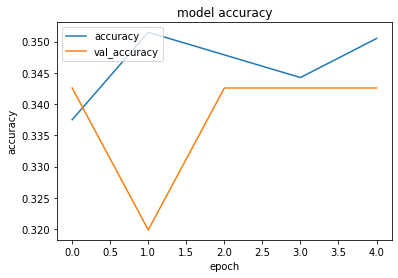

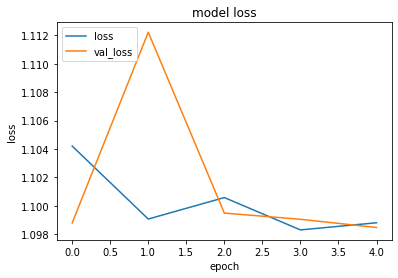

In [32]:
# list all data in history       
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
fig_path = 'accuracy_history.png'
plt.savefig(fig_path)     
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
fig_path = 'loss_history.png'
plt.savefig(fig_path) 
plt.show()

In [33]:
test_preds = model.predict(x_test)
test_preds

array([[0.3357142 , 0.34241986, 0.32186595],
       [0.3356527 , 0.34240884, 0.32193848],
       [0.33565366, 0.3424102 , 0.32193616],
       ...,
       [0.33538842, 0.34226376, 0.32234785],
       [0.33538345, 0.3422627 , 0.3223539 ],
       [0.33540413, 0.34227133, 0.32232457]], dtype=float32)

In [34]:
len(test_preds)

5190

In [35]:
len(x_test)

5190

In [36]:
labels = ['HOLD', 'SELL', 'BUY'] 

pred = []
for i in test_preds:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
for i in y_test:
    real.append(np.argmax(i))
real_array = np.array(real)    

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print('Accuracy Score: ', accuracy_score(real, pred))

Accuracy Score:  0.328131021194605


In [38]:
confusion_matrix = confusion_matrix(real_array, pred_array)
confusion_matrix

array([[   0, 1753,    0],
       [   0, 1703,    0],
       [   0, 1734,    0]], dtype=int64)

In [ ]:
print(classification_report(real, pred))